In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from vae.models import LeNeT5Encoder
from vae.models import LeNeT5Decoder
from vae.models import AE
sns.set_theme()

In [2]:
lr = 1e-3
epochs = 16
batch_size = 64

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [4]:
dataset = datasets.MNIST(
    '../data', 
    train=True, 
    download=True,
    transform=transform,
    )
test = datasets.MNIST(
    '../data', 
    train=False, 
    download=True,
    transform=transform,
)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test, batch_size=batch_size)

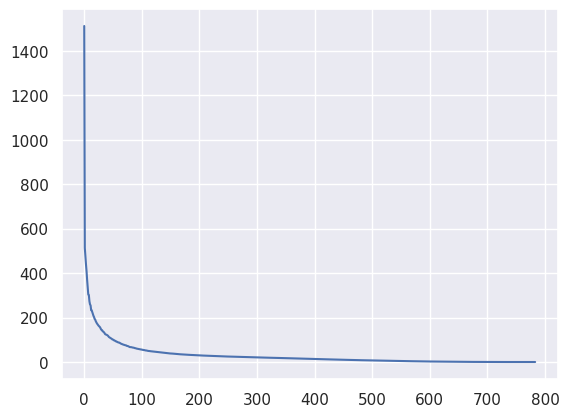

In [5]:
train_tensors = []
for data, target in dataloader:
    train_tensors.append(data.flatten(1))

_, s, _ = torch.cat(train_tensors).svd()


plt.plot(s)

In [6]:
encoder = LeNeT5Encoder(latent_dim=200)
decoder = LeNeT5Decoder(latent_dim=200)

ae = AE(encoder=encoder, decoder=decoder)

In [7]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR


optimizer = AdamW(ae.parameters(), lr=lr)
scheduler = CosineAnnealingLR(optimizer, T_max=epochs * 60000 / batch_size)
loss = torch.nn.BCEWithLogitsLoss()

In [8]:
for epoch in range(4):
    for batch_idx, (data, target) in enumerate(dataloader):
        outs = ae(data)
        loss_value = loss(outs, data)
        loss_value.backward()
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()
        print(loss_value.item())

0.7722315788269043
0.7711493968963623
0.7709453105926514
0.7681089639663696
0.7691267132759094
0.7668874263763428
0.7656958699226379
0.7632666826248169
0.7607000470161438
0.7600293755531311
0.7552778124809265
0.7506279945373535
0.74798184633255
0.7425758242607117
0.7360750436782837
0.7274020314216614
0.7144196033477783
0.6976417899131775
0.6834383606910706
0.671972930431366
0.6518895030021667
0.6474539041519165
0.602433443069458
0.5824893712997437
0.5668401122093201
0.5507328510284424
0.5444942116737366
0.5436685681343079
0.5296343564987183
0.5341809391975403
0.5416927933692932
0.5251685380935669
0.5152247548103333
0.5013852119445801
0.48517075181007385
0.5031269788742065
0.480218768119812
0.4702948331832886
0.4562816619873047
0.46728795766830444
0.4535248875617981
0.4514964818954468
0.44062042236328125
0.44128695130348206
0.44234493374824524
0.4293842613697052
0.3894190788269043
0.41633906960487366
0.3834896385669708
0.37405869364738464
0.36718523502349854
0.35110801458358765
0.387151

(-0.5, 27.5, 27.5, -0.5)

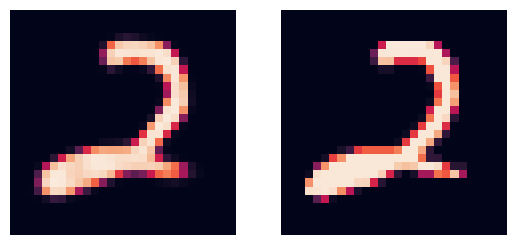

In [9]:
fig, axes = plt.subplots(1, 2)
n = 2
axes[0].imshow(F.sigmoid(outs[n, 0, :, :]).detach().numpy())
axes[0].axis('off')
axes[1].imshow(data[n, 0, :, :].detach().numpy())
axes[1].axis('off')

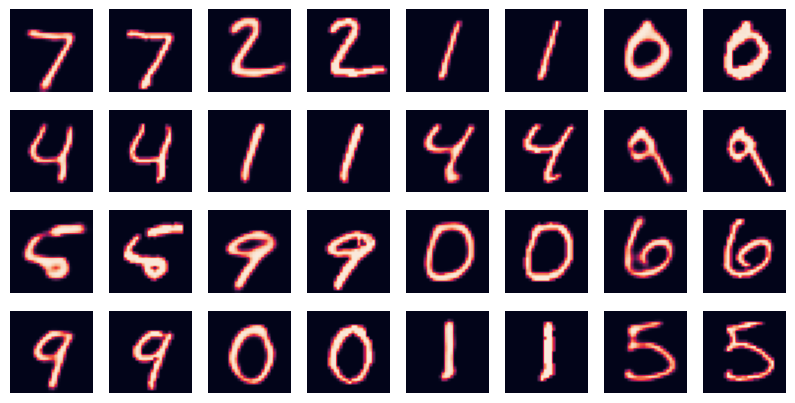

In [10]:
fig, axes = plt.subplots(4, 8, figsize=(10, 5))

imgs = next(iter(test_dataloader))[0]
latents = encoder(imgs)
reconstructed = ae(imgs)
for i in range(16):
    axes[i // 4][(2*i) % 8].imshow(F.sigmoid(reconstructed[i, 0, :, :]).detach().numpy())
    axes[i // 4][(2*i) % 8].axis('off')
    axes[i // 4][(2*i + 1) % 8].imshow(imgs[i, 0, :, :].detach().numpy())
    axes[i // 4][(2*i + 1) % 8].axis('off')

In [11]:
from collections import defaultdict


imgs = next(iter(test_dataloader))[0]
latents = encoder(imgs)


mean_vectors = {k: torch.zeros(1, 1, 28, 28) for k in range(10)}


for vecs, targets in test_dataloader:
    for vec, target in zip(vecs, targets):
        mean_vectors[target.item()] += vec/10000

In [12]:
mean_vectors = torch.cat(list(mean_vectors.values()))

tensor([378.2103, 552.9338, 451.8835, 519.1880, 449.8692, 470.9540, 454.6585,
        463.4875, 484.5149, 489.6440], grad_fn=<SqrtBackward0>)
tensor([421.3482, 553.5429, 429.0556, 451.1574, 470.2584, 422.9520, 466.7246,
        472.5492, 496.5892, 485.7168], grad_fn=<SqrtBackward0>)
tensor([384.8477, 539.5944, 445.1148, 431.7737, 459.6755, 471.3126, 450.3484,
        461.6178, 434.3365, 508.8896], grad_fn=<SqrtBackward0>)
tensor([405.0687, 535.5635, 423.7198, 464.3153, 460.5439, 455.5175, 461.1553,
        523.8704, 445.3654, 461.2751], grad_fn=<SqrtBackward0>)
tensor([430.5810, 495.1096, 434.3289, 437.8408, 512.0132, 422.5171, 481.5817,
        497.9536, 428.4078, 482.5375], grad_fn=<SqrtBackward0>)
tensor([428.1125, 518.9012, 421.5722, 468.4016, 456.2386, 431.3141, 456.7518,
        454.4585, 436.6079, 442.3824], grad_fn=<SqrtBackward0>)
tensor([385.5587, 541.5837, 417.9451, 392.4585, 478.8490, 495.5232, 471.1861,
        493.4062, 453.2870, 513.2855], grad_fn=<SqrtBackward0>)
tensor

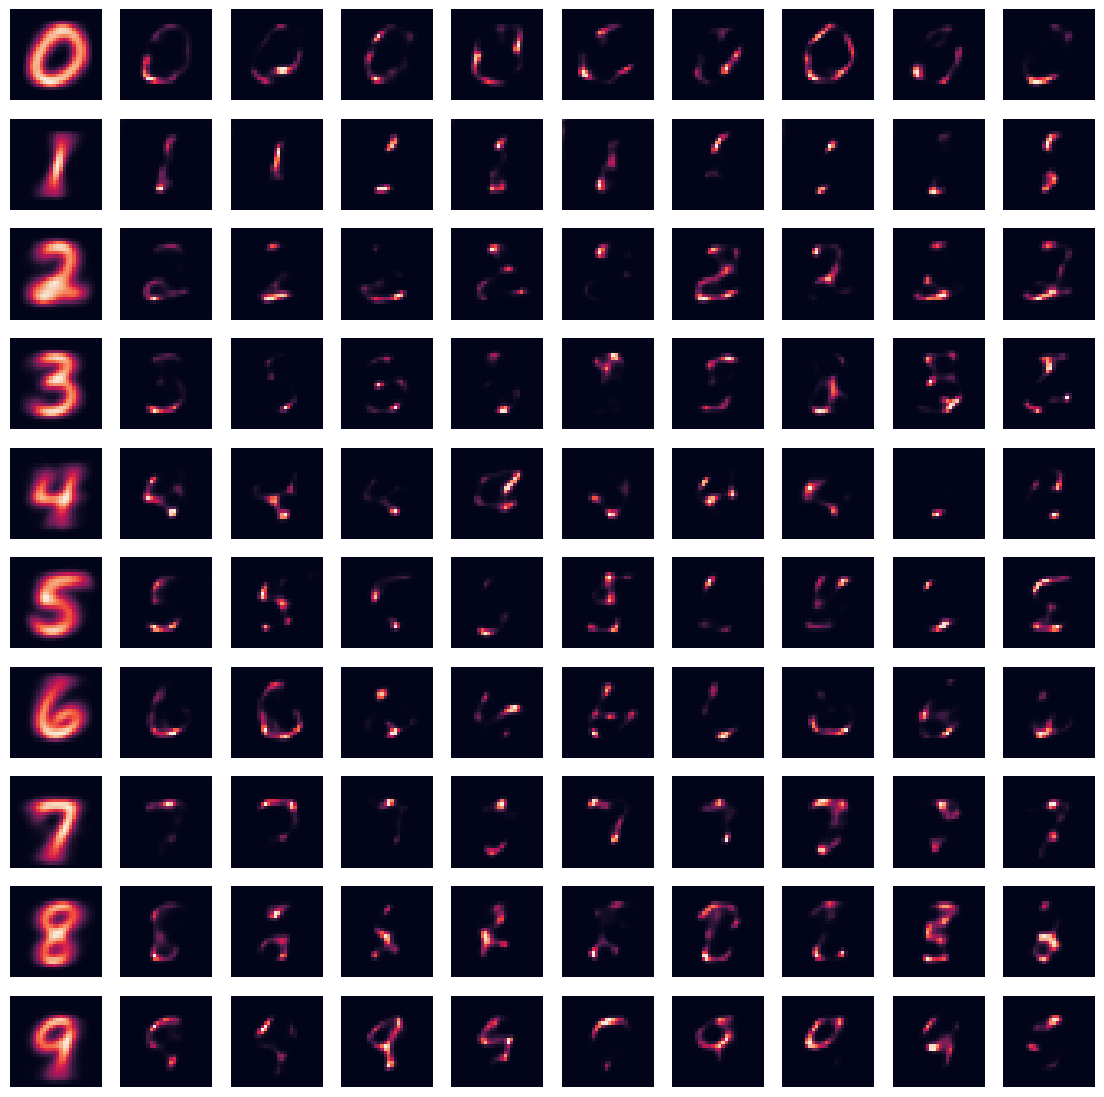

In [17]:
fig, axes = plt.subplots(10, 10, figsize=(14, 14))


for i in range(10):
    axes[i][0].imshow(mean_vectors[i, 0, :, :].detach().numpy())
    axes[i][0].axis('off')


latents = ae.encoder(mean_vectors)
reconstructed = ae.decoder(latents)


for i in range(10):
    axes[i][1].imshow(F.sigmoid(reconstructed[i, 0, :, :]).detach().numpy())
    axes[i][1].axis('off')

for j in range(2, 10):
    vecs = ae.sample_from_latent(means=latents, stds=0.01)
    print(((mean_vectors - vecs)**2).sum(axis=-1).sum(axis=-1).sum(axis=-1).sqrt())
    for i in range(10):
        axes[i][j].imshow(F.sigmoid(vecs[i, 0, :, :]).detach().numpy())
        axes[i][j].axis('off')

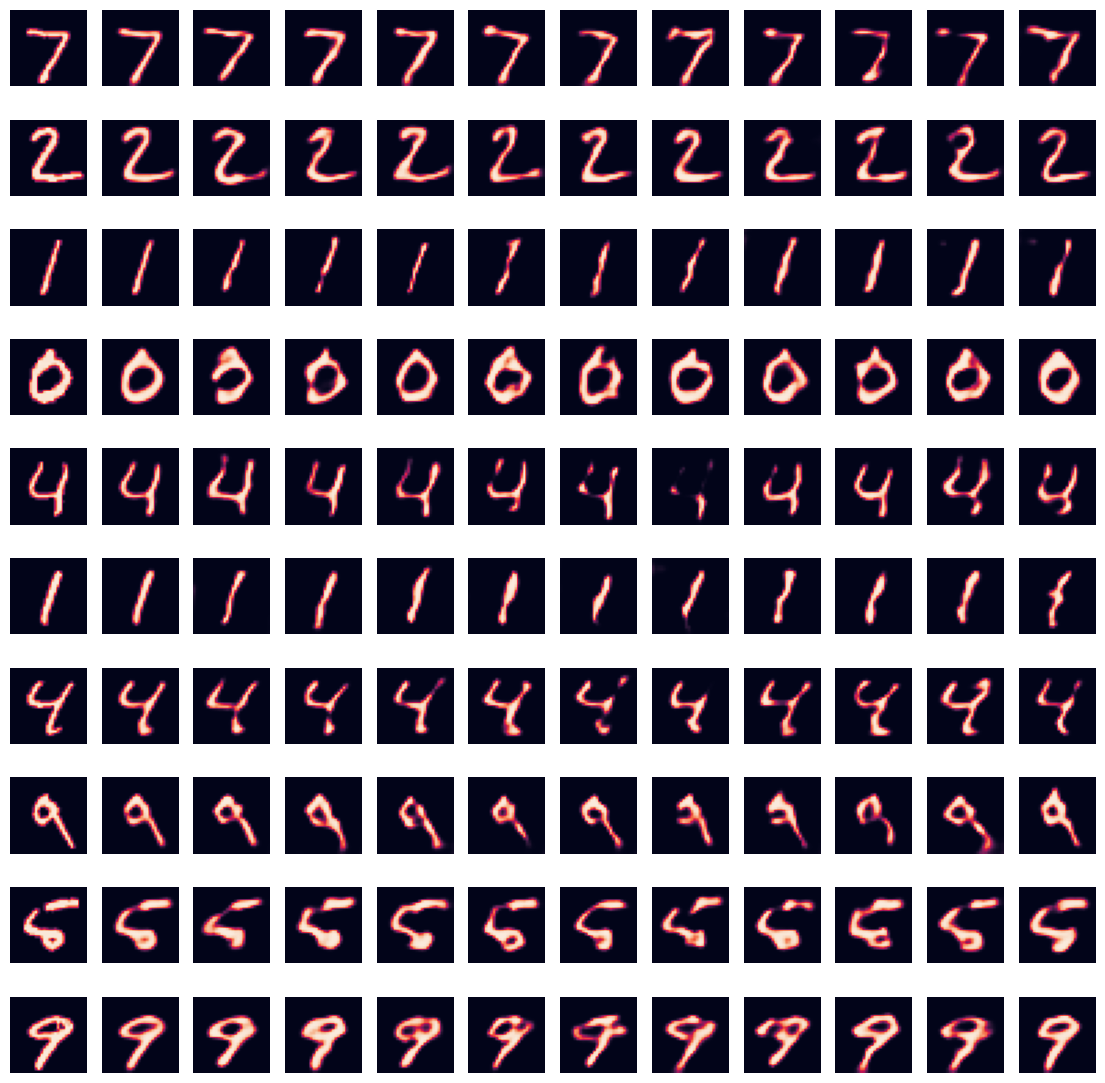

In [26]:
fig, axes = plt.subplots(10, 12, figsize=(14, 14))

vectors, targets = next(iter(test_dataloader))


for i in range(10):
    axes[i][0].imshow(vectors[i, 0, :, :].detach().numpy())
    axes[i][0].axis('off')


latents = ae.encoder(vectors)
reconstructed = ae.decoder(latents)


for i in range(10):
    axes[i][1].imshow(F.sigmoid(reconstructed[i, 0, :, :]).detach().numpy())
    axes[i][1].axis('off')

for j in range(2, 12):
    vecs = ae.sample_from_latent(means=latents, stds=0.2)
    #print(((vectors - vecs)**2).sum(axis=-1).sum(axis=-1).sum(axis=-1).sqrt())
    for i in range(10):
        axes[i][j].imshow(F.sigmoid(vecs[i, 0, :, :]).detach().numpy())
        axes[i][j].axis('off')

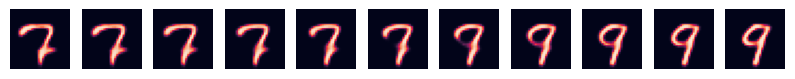

In [14]:
fig, axes = plt.subplots(1, 11, figsize=(10, 10))


vectors, targets = next(iter(test_dataloader))
latents = ae.encoder(vectors)

for j in range(0, 11):
    t = j / 10
    z = latents[12] * t + latents[36] * (1 - t)
    vecs = ae.decoder(z.unsqueeze(0).unsqueeze(0))
    axes[j].imshow(F.sigmoid(vecs[0, 0, :, :]).detach().numpy())
    axes[j].axis('off')

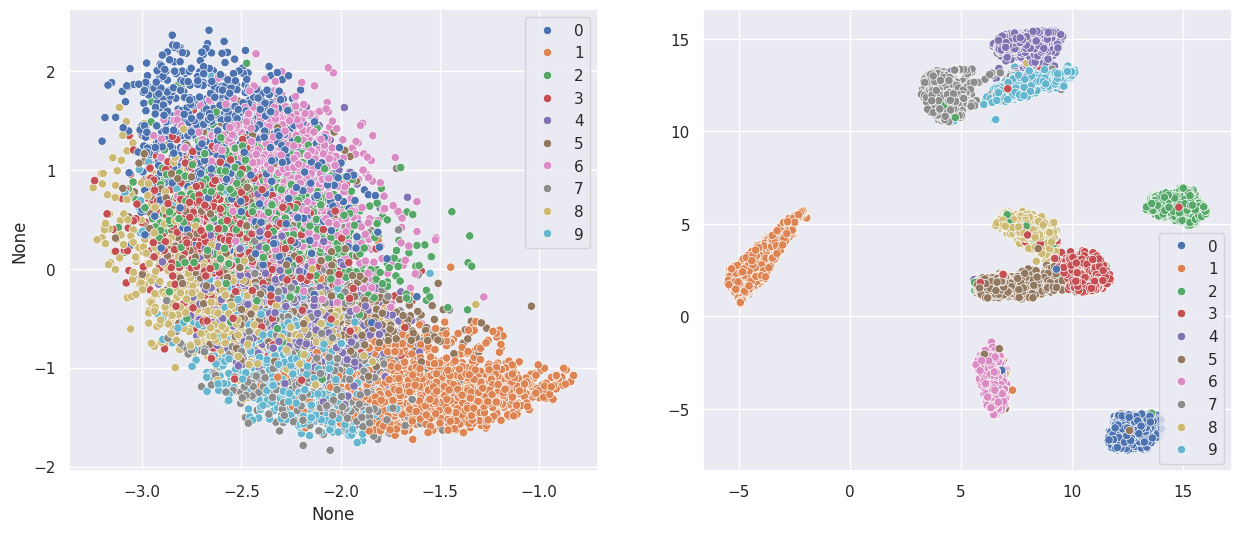

In [15]:
import umap


fig, axes = plt.subplots(1, 2, figsize=(15, 6))
with torch.no_grad():

    latents_list = []
    targets_list = []
    for batch_idx, (data, target) in enumerate(test_dataloader):
        latent = encoder(data)
        latents_list.append(latent)
        targets_list.extend(target.tolist())


    latents = torch.cat(latents_list)
    u, s, vt = latents.svd()
    pc = u[:, :2] @ s[:2].diag()

    fit = umap.UMAP()
    umap2d = fit.fit_transform(latents)
    sns.scatterplot(x=pc[:, 0], y=pc[:, 1], hue=targets_list, palette="deep", ax=axes[0])
    sns.scatterplot(x=umap2d[:, 0], y=umap2d[:, 1], hue=targets_list, palette="deep", ax=axes[1])